## EDA on historical financial ratios data

In this notebook, we'll examine the clustering of stocks based on stock financial ratios data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white")
plt.style.use('default') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

In [2]:
sp500_comp_profile_df = pd.read_csv('../data/stocks_profile.csv')
print(f'Total count of stocks in profile data: {len(sp500_comp_profile_df.ticker.unique())}')
# sp500_comp_profile_df.head()
stocks_hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
stocks_hist_price_df.date = pd.to_datetime(stocks_hist_price_df.date, format='ISO8601')
print(f'Total count of stocks in hist price data: {len(stocks_hist_price_df.ticker.unique())}')
# stocks_hist_price_df.head()
stocks_hist_ratios_df = pd.read_csv('../data/stocks_hist_ratios.csv')
print(f'Total count of stocks in hist ratios data: {len(stocks_hist_ratios_df.ticker.unique())}') 
# stocks_hist_ratios_df.head()

Total count of stocks in profile data: 503
Total count of stocks in hist price data: 503
Total count of stocks in hist ratios data: 502


---

### 1. Data cleanup

There are 5 essential categories of financial ratios, namely, liquidity, leverage, efficiency, profitability & market value ratios. We'll consider the following ratios (2 from each category) which are regarded as the most inflential factors for clustering stocks.

1. Liquidity - Quick ratio [(CCE + ST Inv + AR)/Tot CL];    Cash ratio [CCE/Tot CL]

2. Leverage - Interest coverage [EBIT/int exp];  Debt Equity [LT Debt/Tot SHE]

3. Efficiency - Asset Turnover [Rev/Tot Assets];    Receivables Turnover [Rev/AR] 

4. Profitability - ROA [NI/Tot Assets];    OPM [Op Inc/Rev]

5. Market Value - EV mul [EV/EBITDA];   Payout Ratio [Div paid/NI]

We'll consider the historical annual measures of these 10 financial ratios starting from fiscal year 2010 to 2019 (10 years), and chose to omit the data for further years. This decision is consciously taken so as to avoid any strong biases and influences caused by the Covid-19 pandemic induced market crash and rapid bounce back that could lead to poor stock clustering (leading to poor pair selection later). 

In [3]:
stocks_hist_ratios_df_copy = stocks_hist_ratios_df.copy()

# define the desired target features to train the clustering model
target_ratios = ['Quick ratio', 'Cash ratio', 'Interest coverage', 'Debt equity ratio', 
                 'Asset turnover', 'Receivables turnover', 'Return on assets', 
                 'Operating profit margin', 'Enterprise value multiple', 'Payout ratio']

ratios_df = stocks_hist_ratios_df_copy[['ticker', 'Fiscal Date Ending'] + target_ratios].pivot(
    index='ticker', columns='Fiscal Date Ending', values=target_ratios)

# change the dtypes from object to float
ratios_df = ratios_df.apply(pd.to_numeric, errors='coerce', downcast='float')

# consciously taking a decision to avoid pandemic induced rapid market volatility
# so that clustering of stocks is not negatively impacted; hence considering only pre-pandemic data  
ratios_df = ratios_df[[col_tup for col_tup in ratios_df.columns if col_tup[1] < 2020]]
ratios_df.head() 

Quick ratio                                                                Cash ratio                                                                Interest coverage                                                                             Debt equity ratio                                                                                     Asset turnover                                                                Receivables turnover                                                                                        Return on assets                                                                Operating profit margin                                                                Enterprise value multiple                                                                                           Payout ratio                                                               
Fiscal Date Ending        2010   2011   2012   2013   2014   2015   2016   2017   2018   2019       2010   2011   2012   2013   2014   2015   2016   2017   2018   2019              2010    2011       2012       2013   2014    2015   2016    2017    2018    2019              2010   2011   2012       2013       2014    2015    2016    2017        2018        2019           2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                 2010       2011       2012    2013       2014       2015       2016    2017    2018    2019             2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                    2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                      2010       2011    2012       2013    2014       2015       2016    2017       2018       2019         2010   2011   2012   2013   2014   2015   2016   2017   2018   2019
ticker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
A                        1.141  2.388  1.730  2.231  2.357  2.673  3.090  2.694  2.582  1.112      0.859  1.920  1.242  1.670  1.779  2.052  2.422  2.120  1.919  0.664             5.896  12.453  11.079000   8.888000  7.354   7.909  8.542  10.646  12.373  12.716             2.001  1.101  1.033   1.021000   1.044000   0.794   0.838   0.743    0.869000    0.991000          0.561  0.730  0.651  0.635  0.645  0.540  0.539  0.531  0.575  0.546             6.265000   7.692000   7.430000   7.544   7.102000   6.663000   6.659000   6.177   6.332   5.552            0.071  0.112  0.109  0.068  0.047  0.054  0.059  0.081  0.037  0.113                   0.104  0.162  0.163  0.140  0.119  0.129  0.146  0.188  0.189  0.182                    10.238   5.791000   6.585   9.956000  12.780  18.257999  16.552999  20.466  18.796000  21.959999        0.000  0.000  0.090  0.215  0.349  0.332  0.325  0.249  0.604  0.192
AAL                      0.596  0.568  0.539  0.783  0.675  0.564  0.573  0.456  0.357  0.305      0.019  0.033  0.052  0.083  0.074  0.029  0.023  0.020  0.015  0.015             0.374  -1.341   0.175000   1.634000  4.790   7.050  5.332   3.854   2.515   2.799            -7.359 -4.354 -3.944 -16.481001  20.658001   7.592  12.547  12.091 -359.462006 -509.432007          0.884  1.0

In [4]:
ratios_df.describe(include='all').T

count       mean        std         min        25%        50%        75%         max
                          Fiscal Date Ending                                                                                      
Quick ratio               2010                403.0   1.547750   2.940032    0.032000   0.685500   1.088000   1.763000   55.495998
                          2011                409.0   2.764086  27.809965    0.030000   0.644000   1.029000   1.604000  563.148010
                          2012                419.0   2.043482  12.734620    0.054000   0.612500   1.000000   1.719500  260.470001
                          2013                425.0   3.694656  44.913990    0.034000   0.634000   1.056000   1.666000  926.494019
                          2014                422.0   1.455225   1.979606    0.043000   0.605000   0.973500   1.700250   27.190001
                          2015                432.0   1.963662  11.844609    0.025000   0.579500   0.956000   1.582000  244.289001
                          2016                441.0   1.393342   1.823818    0.021000   0.617000   1.015000   1.602000   27.457001
                          2017                443.0   1.367598   1.728180    0.027000   0.589500   0.959000   1.496500   24.090000
                          2018                445.0   1.719757  10.624504    0.025000   0.540000   0.901000   1.334000  223.845993
                          2019                446.0   1.206166   1.230847    0.027000   0.530750   0.874000   1.398000    9.860000
Cash ratio                2010                403.0   0.669876   0.977657    0.000000   0.179000   0.409000   0.829500   13.096000
                          2011                409.0   1.058892   8.812542    0.002000   0.155000   0.373000   0.701000  177.957993
                          2012                419.0   0.818210   4.719163    0.004000   0.153000   0.357000   0.714000   95.848000
                          2013                425.0   1.381393  14.546450    0.005000   0.159000   0.380000   0.724000  299.088013
                          2014                422.0   0.675879   1.537980    0.002000   0.127750   0.360500   0.755750   24.160000
                          2015                432.0   0.772935   3.394882    0.002000   0.127500   0.334000   0.709250   64.181999
                          2016                441.0   0.629066   1.441019    0.003000   0.146000   0.334000   0.714000   25.106001
                          2017                443.0   0.631916   1.342425    0.000000   0.127000   0.320000   0.695500   21.615000
                          2018                445.0   0.992175   9.945877    0.001000   0.091000   0.258000   0.581000  209.615005
                          2019                446.0   0.536608   0.853546    0.003000   0.097250   0.265000   0.599000    7.234000
Interest coverage         2010                214.0  16.592482  83.191078 -305.000000   0.000000   3.686000  11.575000  950.052002
                          2011                218.0  12.717921  75.750862 -781.000000   0.893500   4.426500  14.047000  637.450989
                          2012                227.0  18.830847  63.487953 -126.500000   0.352500   4.831000  13.514000  582.000000
                          2013                234.0  19.656248  76.058990  -39.747002   1.522750   4.964500  14.144751  923.968018
                          2014                235.0  14.881166  34.917881  -45.923000   1.289500   5.695000  13.823500  312.717010
                          2015                242.0  16.859278  51.573666  -47.382000   0.610500   5.078500  12.118501  459.076996
                          2016                246.0  14.483618  43.180481  -22.611000   0.501000   4.610000  10.652500  442.954987
                          2017                248.0  14.583219  55.402035  -40.791000   1.200250   4.557500   9.904751  735.757019
                          2018                248.0  12.470008  39.869617  -25.686001   1.183750   4.865000  10.8492

---

### 2. Pre-processing

##### Imputation of Missing Values

Generally we impute Missing Values or 'NaN' values before proceeding to Machine Learning

Common ways of Imputation:

1. Drop Rows or Columns
2. Mean , Mode, median
3. Use ML techniques to impute missing values 

First method is the most simplistic and preferred option for data imputation. But, this approach is alright so long as the sample dataset  is large enough to not have adverse effect on model fitting as a result of losing key training data because of dropping either features or sample records. some does work. In our case, we have a limited sample size (only 500 stocks), so we avoid this option and look for others. What we can do is we can group companies on their sectors and try to impute missing values using nearest neighbours or sector mean/median values for specific ratios. This may come handy, but lets put it aside for now. 

Second method does not make a strong case in our consideration as all companies have their independent attributes. Although we could fill in the missing values for a company's specific ratio by computing mean measure of the ratio in consideration across time periods. But this method is complicated and we'll table it for now.

Third method is the most advanced approach of using ML algorithms like regression and KNN techniques to logically impute the missing values rather than mannually handling the missing values. This is considered a robust imputation technique in most cases.

There is one another Brute Force way of imputing and that is finding real values by going through company websites, annual reports, etc. But this method is susceptible to human errors and hence we'll avoid it.

Lets go through the data and do some Exploratory Data Analysis and then choose method that perfectly suits the situation.

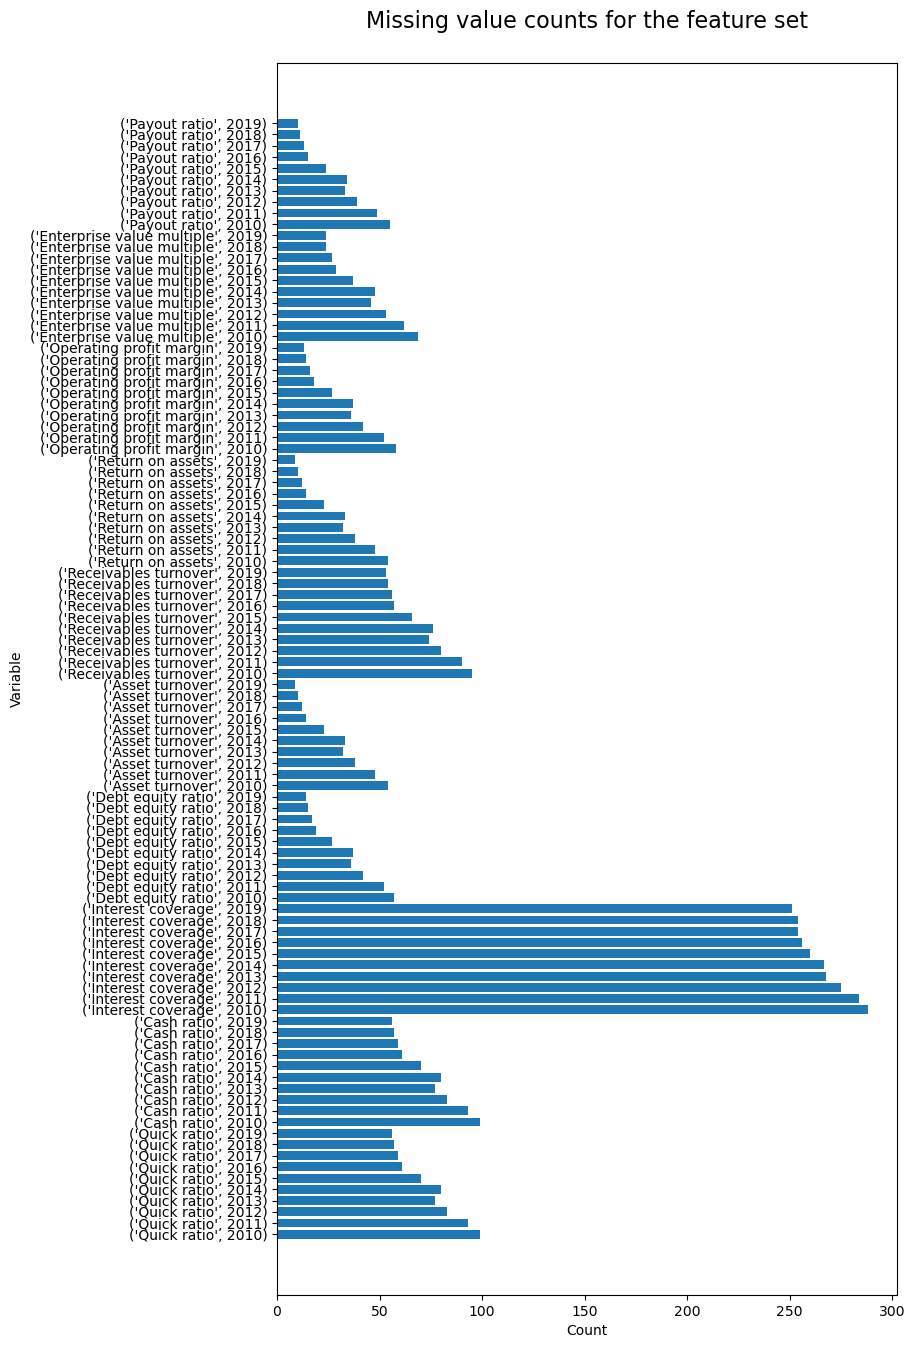

In [5]:
# Plot missing value counts for variables across time periods
plt.figure(figsize=(8, 16))
plt.barh(range(len(ratios_df.columns)), ratios_df.isna().sum())
plt.title('Missing value counts for the feature set\n', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Variable')
plt.yticks(ticks=range(len(ratios_df.columns)), labels=ratios_df.columns)
plt.show() 

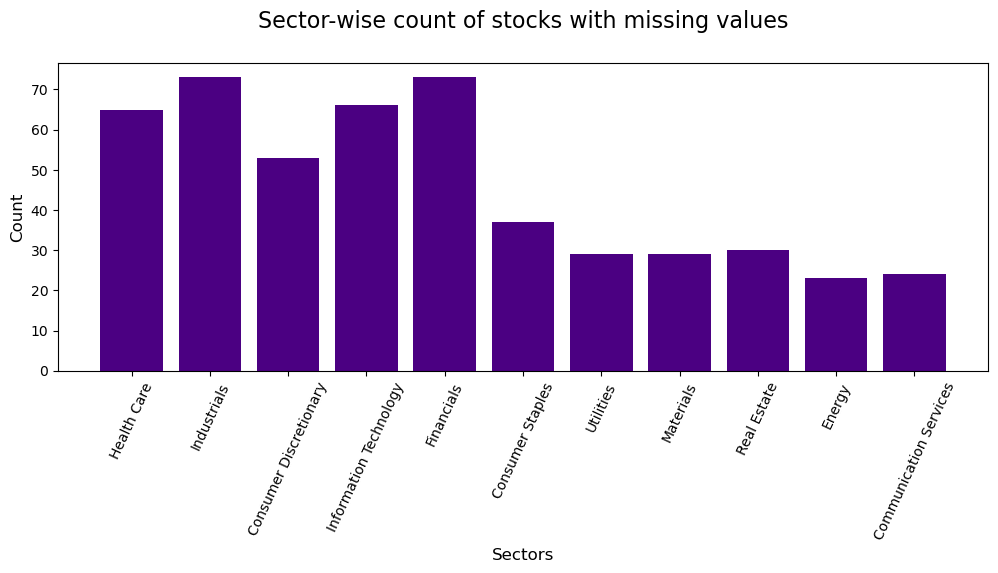

In [6]:
# Plot sector wise counts of missing values
sector_counts = Counter([sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] 
                         for tkr in ratios_df[ratios_df.isna()].index])
plt.figure(figsize=(12, 4))
plt.bar(sector_counts.keys(), sector_counts.values(), color='indigo')
plt.title('Sector-wise count of stocks with missing values\n', fontsize=16)
plt.xlabel('Sectors', fontsize=12)
plt.xticks(rotation=65)
plt.ylabel('Count', fontsize=12)
plt.show() 

<Axes: title={'center': 'Missing value correlation matrix for the feature set\n'}, xlabel='None-Fiscal Date Ending', ylabel='None-Fiscal Date Ending'>

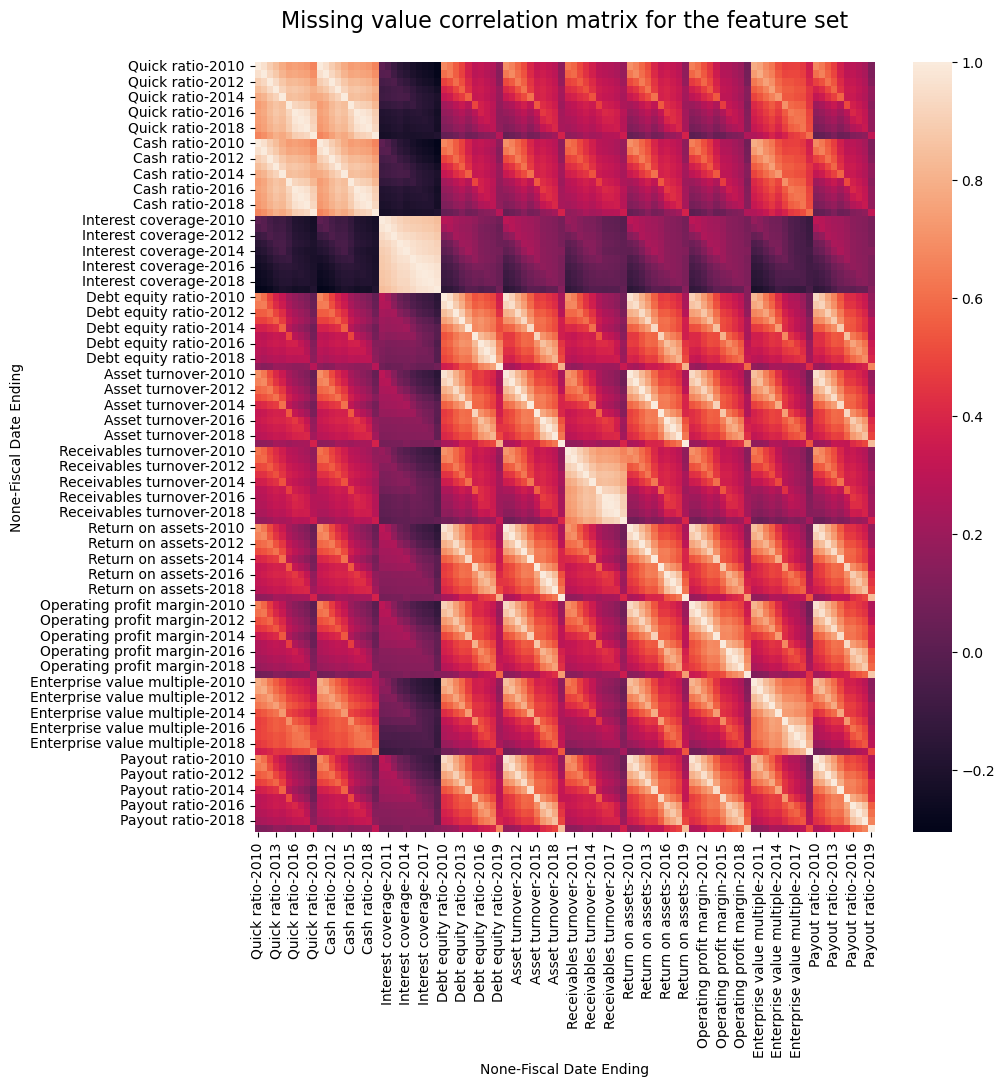

In [7]:
# Nullity corr between variables (correlation between features based on their missing values) 
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Missing value correlation matrix for the feature set\n', fontsize=16)
sns.heatmap(ratios_df.isna().corr(), ax=ax)

##### Observations:

1. There are higher proportions of missing values for all the ratios for earlier years of the dataset (2010, 2011, 2012, 2013). This is understandable because some of the current S&P 500 companies were not yet listed on public bourses then, and thereby account for larger part of the missing values.

2. Interest coverage seems to have missing values for almost half the size of the dataset (half of all stocks). This is very high considering a relatively smaller dataset in the first place. We could drop this ratio altogether and perhaps look at some other ratio. Else, we could consider some ML based imputation technique to fill up missing values.

3. Financials, Technology, Industrials and Health Care stocks account for the highest number of missing values in the dataset. 

3. Based on Nullity corr check, 'Quick ratio' and 'Cash ratio' seem to have near zero corr with all other variables, indicating no interdependence on missing values in other variables. However, both of these along with 'Receivables Turnover' & 'Interest coverage' ratio have extremely high corr with their own values across time periods. This means if there's any data missing for these features in a certain fiscal year, chances are there are missing values across all other periods as well, and probably point to the same stock.   

Let's try imputing missing values using some advanced ML technique:

1. K-Nearest Neighbour (KNN) Imputation:

    An alternative way to impute missing values is to predict them. Nearest neighbor imputation is widely used and proven to be an effective way of missing value imputation. Here, missing values are imputed using the mean value from K-nearest neighbors found in the training set. KNNImputer can work with continuous, discrete and categorical data types but not with text data. However, defining the number of neighbors — k can be tricky since it introduces a trade-off between robustness and speed. If we select a small k then we have fast computation but less robust results. In contrast, if we select a large k, then we have a more robust but slow computation.

2. Multivariate Imputation by Chained Equation — MICE:

    A way to impute missing values is to predict them. MICE is a method for imputation of missing values in multivariate data. It is based on the idea of chained equation. The idea is to find the best way to predict missing values in a given column. The algorithm is based on the idea of iteratively predicting missing values in a given column.

In [8]:
# Imputing with KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

def knn_imputer(data: pd.DataFrame):
    """
    Imputing with KNNImputer
    """
    # scale the data using minmaxscaler
    scaled_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data)
    # Define KNN imputer and fill missing values
    knn_fit_data = KNNImputer(n_neighbors=30, weights='distance').fit_transform(scaled_data)
    new_df = pd.DataFrame(knn_fit_data, columns=data.columns, index=data.index)

    # check if there are any more missing values after imputation
    print(f'Total count of missing values after imputing with KNNImputer: {new_df.isna().sum().sum()}')
    return new_df

ratios_imputed_df = knn_imputer(ratios_df)

Total count of missing values after imputing with KNNImputer: 0


In [9]:
# # Imputing with MICE
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn import linear_model

# def mice_imputer(data: pd.DataFrame):
#     """
#     Imputing with MICE
#     """
#     # Define MICE Imputer and fill missing values
#     mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
#     new_df = pd.DataFrame(mice_imputer.fit_transform(data), columns=data.columns, index=data.index)

#     # check if there are any more missing values after imputation
#     print(f'Total count of missing values after imputing with KNNImputer: {new_df.isna().sum().sum()}')
#     return new_df

# ratios_imputed_df = mice_imputer(ratios_df)

##### Conclusion from data imputation:

We observed the following Silhouette score for various n_neighbour values for the KNN imputer:

    - for n_neighbour (K) = 25, SS = 0.19641587138175964 with k = 11 (K-means)
    - for n_neighbour (K) = 30, SS = 0.20030252635478973 with k = 12 (K-means)
    - for n_neighbour (K) = 40, SS = 0.18952003121376038 with k = 11 (K-means)

We observed that the KNN imputer yielded a better clustering result (measured by silhouette score over a K-means fit). So we decided that pick KNN imputation method over MICE. 

To pick an optimal 'K' value for the KNN imputer model, we tested the clustering performance over a range of values for 'K' (n_neighbour) and found that the clusters were better formed for n_neighbour value of 30.

---

### 3. Clustering stocks based on their historical financial ratios data

#### 3.1 PCA for dimensionality reduction

In [10]:
# Standardise & normalise data
def std_normalise_data(data = pd.DataFrame()):
    """
    Standardise & normalise input data
    """
    new_data = StandardScaler().fit_transform(data)
    new_data = Normalizer().fit_transform(new_data) 
    new_df = pd.DataFrame(new_data, index=data.index, columns=data.columns)
    return new_df

ratios_imp_norm_df = std_normalise_data(ratios_imputed_df)
ratios_imp_norm_df.head()

Quick ratio                                                                                           Cash ratio                                                                                           Interest coverage                                                                                           Debt equity ratio                                                                                           Asset turnover                                                                                           Receivables turnover                                                                                           Return on assets                                                                                           Operating profit margin                                                                                           Enterprise value multiple                                                                                             
Fiscal Date Ending        2010      2011      2012      2013      2014      2015      2016      2017      2018      2019       2010      2011      2012      2013      2014      2015      2016      2017      2018      2019              2010      2011      2012      2013      2014      2015      2016      2017      2018      2019              2010      2011      2012      2013      2014      2015      2016      2017      2018      2019           2010      2011      2012      2013      2014      2015      2016      2017      2018      2019                 2010      2011      2012      2013      2014      2015      2016      2017      2018      2019             2010      2011      2012      2013      2014      2015      2016      2017      2018      2019                    2010      2011      2012      2013      2014      2015      2016      2017      2018      2019                      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019   
ticker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
A                    -0.079019 -0.049348 -0.052099 -0.054990  0.164123 -0.029643  0.319057  0.264834 -0.024745 -0.015974   0.038684 -0.018782 -0.020481 -0.040756  0.253946  0.062404  0.424703  0.378990 -0.021929  0.058043         -0.062931 -0.001135 -0.044704 -0.056515 -0.096093 -0.075488 -0.066002 -0.041293 -0.008323  0.005520          0.007076 -0.016343 -0.026861 -0.073158 -0.006153 -0.003810 -0.058883 -0.028764 -0.012660  0.012703      -0.104868 -0.034753 -0.061917 -0.065557 -0.061771 -0.096631 -0.085365 -0.084089 -0.069452 -0.069273            -0.082017 -0.065709 -0.065463 -0.056463 -0.064281 -0.069908 -0.076630 -0.079224 -0.075565 -0.081961         0.047233  0.202897  0.202404  0.018063 -0.098251 -0.003102  0.000365  0.100936 -0.149205  0.185808               -0.031150  0.033275  0.045611 -0.029295 -0.074563  0.004128  0.011496  0.079529  0.061564  0.030258                 -0.011737 -0.117302 -0.032315 -0.027151 -0.011149  0.092506 -0.000461  0.030443  0.046560  0.045366  \
AAL                  -0.019601 -0.009918 -0

Method 1 - variance explained by components

---------------------------------------------------------------------

Method 2 - Scree plot
Knee point, eigenvalue : (12, 0.063552245)


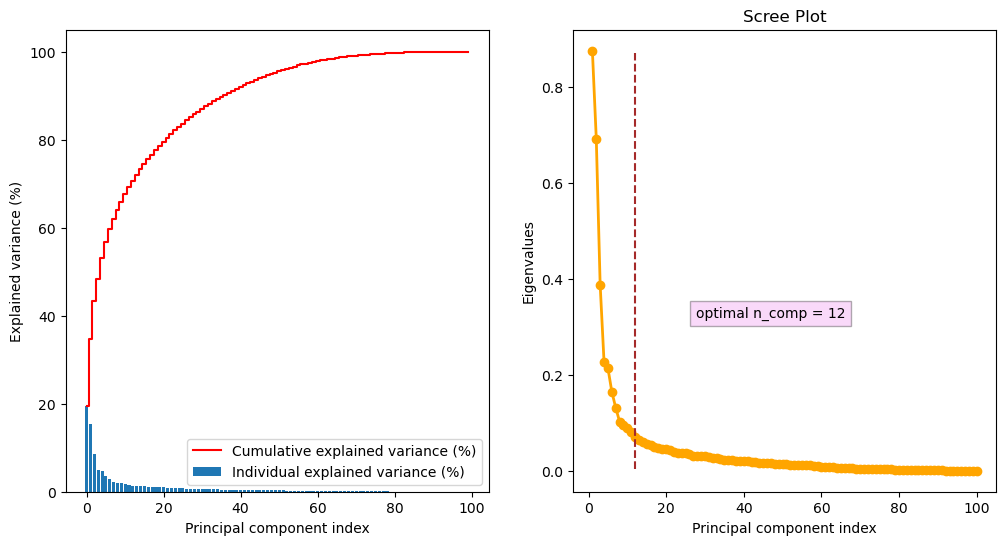

In [11]:
def pca_tuning(data = pd.DataFrame()):
    """
    PCA tuning 
    method 1 - Plot the cummulative explained variance against the count of principal components
    method 2 - Create a Scree plot which gives the visual representation of eigenvalues 
    that define the magnitude of eigenvectors (principal components)
    """
    # Start with basic PCA, keeping all components with no reduction   
    pca_base = PCA()
    pca_base.fit(data)

    plt.figure(figsize=(12, 6))
    # Method 1
    # Fetch variance explained by each individual component & compute the cummulative sum
    print('Method 1 - variance explained by components') 
    plt.subplot(1, 2, 1)
    exp_var = pca_base.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)
    plt.bar(range(0, exp_var.size), exp_var, align='center', label='Individual explained variance (%)')
    plt.step(range(0, cum_exp_var.size), cum_exp_var, where='mid', label='Cumulative explained variance (%)', color='red')
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')

    # Method 2 - Scree plot
    print('\n---------------------------------------------------------------------\n')
    print('Method 2 - Scree plot')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(pca_base.n_components_) + 1, pca_base.explained_variance_, 'ro-', linewidth=2,  color='orange')
    knee = KneeLocator(np.arange(pca_base.n_components_) + 1, pca_base.explained_variance_, S=20, 
                       curve='convex', direction='decreasing', interp_method='interp1d')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    plt.figtext(0.65, 0.4, f'optimal n_comp = {knee.knee}', bbox=dict(facecolor='violet', alpha=0.3), fontsize=10)
    plt.title("Scree Plot")
    plt.xlabel("Principal component index")
    plt.ylabel("Eigenvalues")
    print(f'Knee point, eigenvalue : {knee.knee, pca_base.explained_variance_[knee.knee]}')
    plt.show()

    return pca_base, knee.knee

# Note: PCA needs the input data to be in (n_features, n_samples) format
# for it to function properly and reduce the feature dimensionality
pca_base, knee_point_comps = pca_tuning(ratios_imp_norm_df.T)

##### Method 1:
 The number of bars is equal to the number of variables in the original dataset. In this plot, each bar shows the explained variance percentage of individual components and the step plot shows the cumulative explained variance percentages. By looking at this plot, we can easily decide how many components hold the highest significance.

##### Method 2:
 Scree Plot which is the visual representation of eigenvalues that define the magnitude of eigenvectors (principal components). We select all the components up to the point where the bend occurs in the Scree Plot. In our case, the scree plot hints that n_components=12.

So, we finally decide to go with n_components=12 to fit PCA model on our historical ratios data and obtain the new feature components.

In [12]:
pca_final = PCA(n_components=knee_point_comps) # picked from earlier test
pca_final.fit(ratios_imp_norm_df.T) # Note: we need to input data in the exact required format here for the PCA to work properly

ratios_final_df = pd.DataFrame(pca_final.components_.T, index=ratios_imp_norm_df.index)
print(ratios_final_df.shape)
ratios_final_df.head()

(502, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
ticker,,,,,,,,,,,,
A,-0.022969,0.019944,0.084427,0.011230,0.067876,-0.007983,0.017132,0.033416,-0.053688,0.009440,-0.009415,0.005836
AAL,0.013973,-0.002227,0.000065,0.041388,-0.042296,0.014623,0.055222,-0.008971,0.006203,-0.002929,-0.025204,0.009066
AAP,0.073184,-0.003852,-0.067579,0.014469,-0.020861,-0.080247,-0.020342,0.017345,-0.047462,-0.011702,0.011523,-0.004497
AAPL,0.003832,0.097813,0.023742,-0.052069,-0.038235,-0.043790,0.009940,0.040139,-0.003499,0.019441,0.032590,-0.008906
ABBV,-0.039130,0.052739,0.017161,-0.010375,0.039273,0.021851,0.058013,0.018162,-0.001288,-0.013670,-0.018679,-0.085034


Text(0.5, 1.0, 'Feature space correlation after PCA')

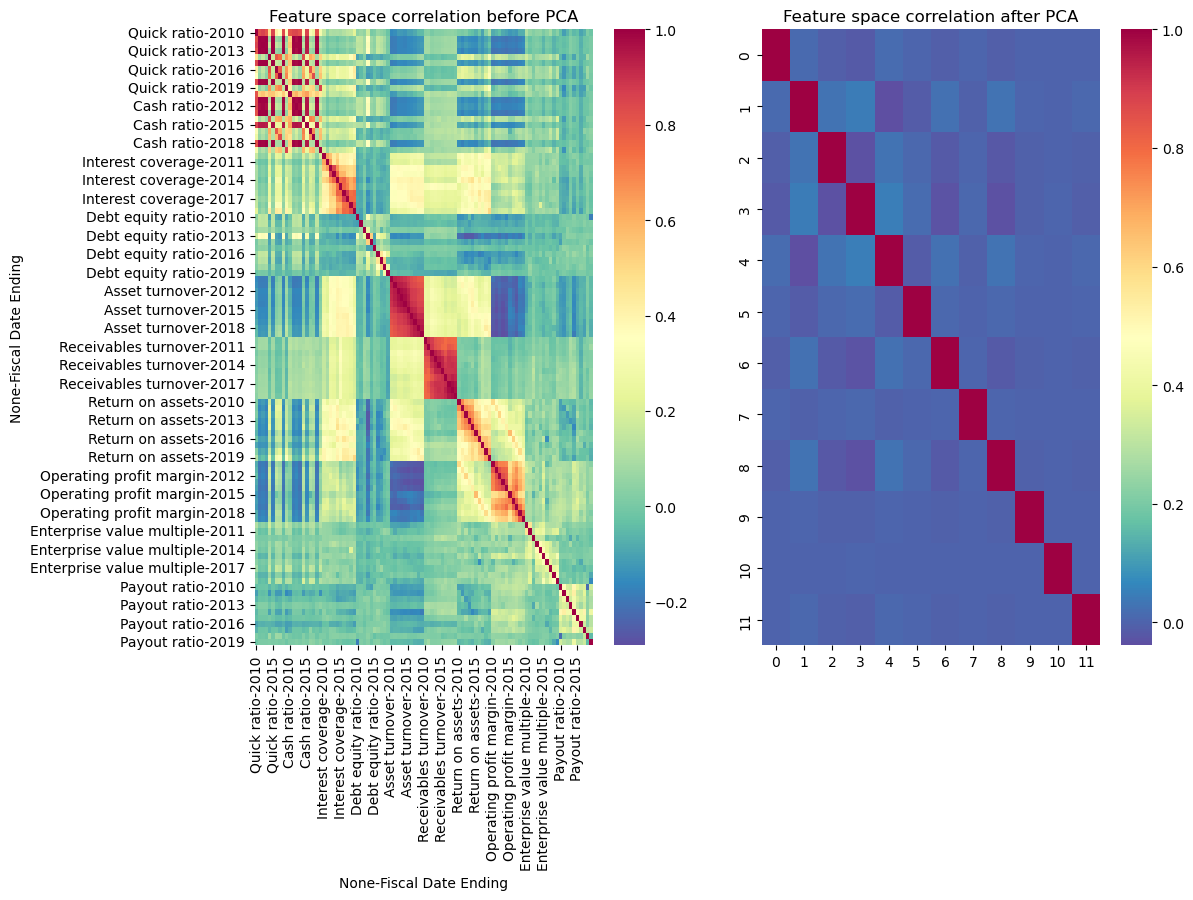

In [13]:
# Lastly, check if new data with reduced dimensions shows any high correlation & compare with data before dimensionality reduction.
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.heatmap(ratios_imp_norm_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation before PCA')
plt.subplot(1,2,2)
sns.heatmap(ratios_final_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation after PCA')

As we can see from the above heatmaps, the principal components computed by the PCA have extremely low correlation. Job well done, PCA! 

***

#### 3.2 K-means Clustering

##### Baseline K-means model

Train a K-means with a pre-defined number of clusters - 11, which follows the sector breakdown based on the GICS norms specified by MSCI. S&P 500 uses the same classification rules.   

In [14]:
# Standardise data for clustering 
ratios_final_norm_df = std_normalise_data(ratios_final_df)
ratios_final_norm_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
ticker,,,,,,,,,,,,
A,-0.152433,0.090898,0.697746,0.167322,0.456979,-0.081757,0.173242,0.244520,-0.364786,0.080155,-0.074666,0.057180
AAL,0.162708,-0.101589,0.061497,0.506622,-0.502607,0.113959,0.584918,-0.098451,0.120329,-0.017651,-0.244911,0.102780
AAP,0.529880,-0.085157,-0.429598,0.175601,-0.212590,-0.576999,-0.104122,0.111305,-0.288873,-0.073706,0.077254,-0.019641
AAPL,0.049749,0.662901,0.220658,-0.312930,-0.351822,-0.338966,0.112767,0.282451,0.020202,0.149304,0.234152,-0.052667
ABBV,-0.276799,0.346230,0.181100,-0.001627,0.235386,0.146370,0.488687,0.128818,0.038290,-0.096210,-0.145757,-0.637574


In [15]:
def kmeans_baseline(data = pd.DataFrame(), init_method: str='k-means++'):
    """
    Runs a baseline K-means clustering model with k=11.
    """
    kmeans_11 = KMeans(n_clusters = 11, init=init_method, max_iter = 20000, n_init=10, random_state=1500)
    kmeans_11.fit(data)

    # predict the clusters for all stocks
    kmeans_11_clusters = pd.DataFrame(index=data.index, columns=['cluster', 'sector'])
    kmeans_11_clusters['cluster'] = list(kmeans_11.predict(data))
    kmeans_11_clusters['sector'] = [sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] for tkr in kmeans_11_clusters.index]
    kmeans_11_clusters['cluster'].value_counts()

    return kmeans_11_clusters, kmeans_11

km_baseline_1_df, km_baseline_1 = kmeans_baseline(ratios_final_norm_df)
km_baseline_2_df, km_baseline_2 = kmeans_baseline(ratios_final_norm_df, init_method='random')

 'k-means++' selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is "greedy k-means++". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.

'random' choose n_clusters observations (rows) at random from data for the initial centroids.

Observations:

 1. The baseline K-means model (with k=11) results are pretty much similar in both the cases as can be seen above. So the choice of sampling technique is not having a major impact on stock clustering.

KMeans clusters stacked against sectors (kmeans++ initialisation)


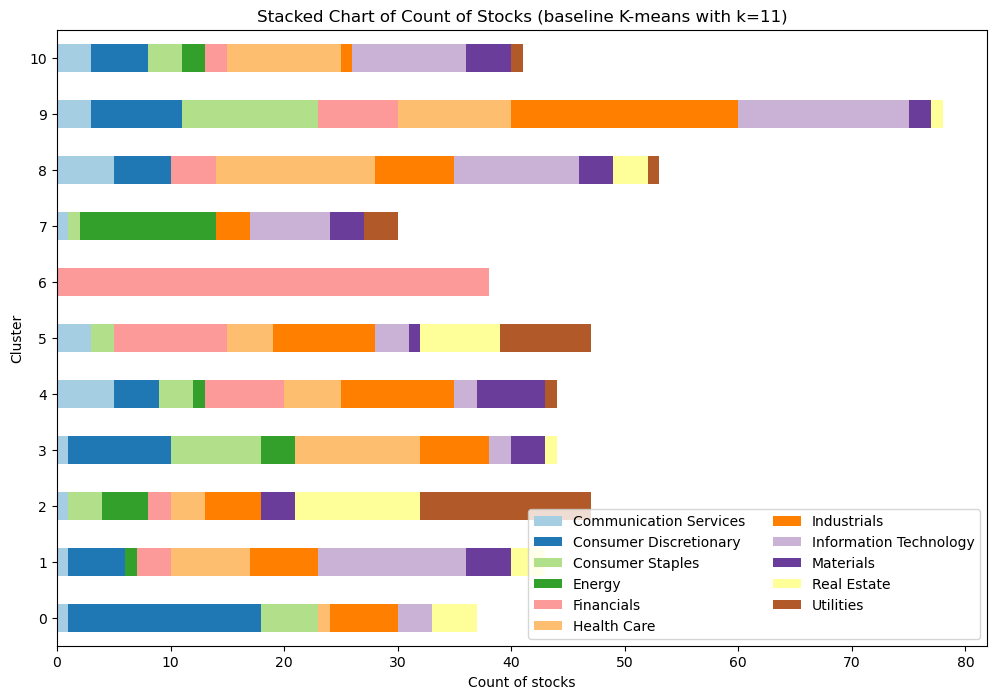

KMeans clusters stacked against sectors (random initialisation)


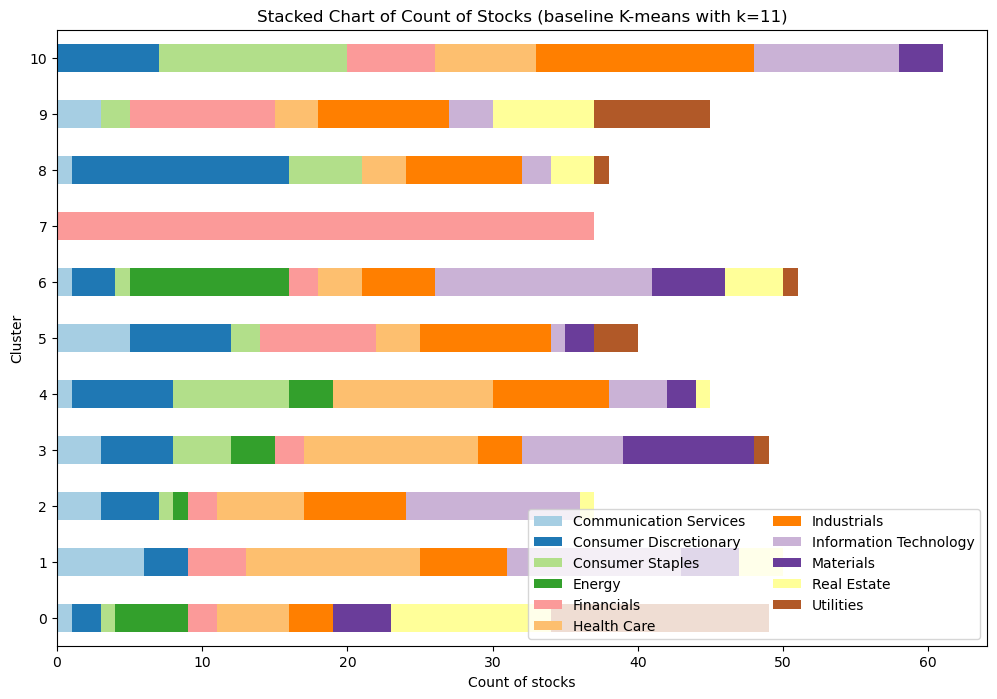

In [16]:
def plot_sector_cluster_stacked_chart(cluster_df=pd.DataFrame()):
    """
    Plot stacked chart of count of stocks across sectors & clusters.
    """
    cross_tab = pd.crosstab(index=cluster_df.cluster, columns=cluster_df.sector)
    cross_tab.plot(kind='barh', stacked=True, colormap=cm.Paired, figsize=(12, 8))
    plt.legend(loc="best", ncol=2)
    plt.ylabel("Cluster")
    plt.xlabel("Count of stocks")
    plt.title("Stacked Chart of Count of Stocks (baseline K-means with k=11)")
    plt.show()


print('KMeans clusters stacked against sectors (kmeans++ initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_1_df)

print('KMeans clusters stacked against sectors (random initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_2_df)

##### Method 1: Elbow method of choosing 'k'

Within-cluster variance is a measure of compactness of the cluster. Lower the value of within cluster variance, higher the compactness of cluster formed.

Sum of within-cluster variance, W, is calculated for clustering analyses done with different values of k. W is a cumulative measure how good the points are clustered in the analysis. Plotting the k values and their corresponding sum of within-cluster variance helps in finding the number of clusters. Initially, error measure (within-cluster variance) decreases with increase in cluster count. After a particular point, say k, Error measure starts flattening. Let's check the value of 'k' in our case

Knee point, WCSS : (12, 234.90103149414062)


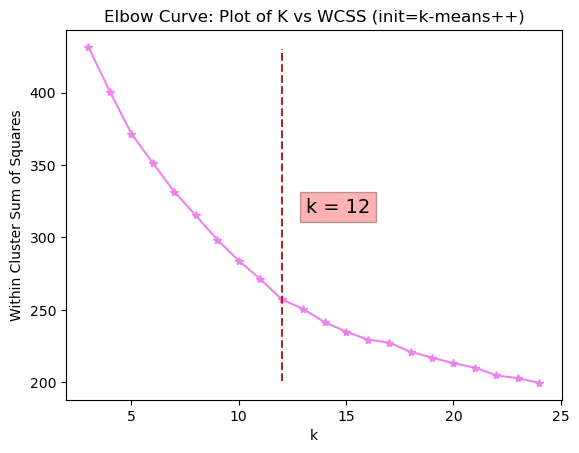

In [17]:
def plot_elbow_curve(data = pd.DataFrame(), k_min: int=2, k_max: int=50, init: str='k-means++'):
    """
    Plot the elbow curve to find optimal 'k' for k-means.
    """
    WSS = []
    k_range = range(k_min, k_max) 
    for k in k_range:
        km = KMeans(n_clusters = k, init=init, max_iter=20000, n_init=10, random_state=1500)
        km.fit(data)
        WSS += [km.inertia_]
   
    plt.plot(k_range, WSS, color='violet', marker='*')
    plt.xlabel('k')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.title(f'Elbow Curve: Plot of K vs WCSS (init={init})')
    knee = KneeLocator(k_range, WSS, curve='convex', direction='decreasing', interp_method='interp1d')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    print(f'Knee point, WCSS : {knee.knee, WSS[knee.knee]}')
    plt.figtext(0.5, 0.5, f'k = {knee.knee}', bbox=dict(facecolor='red', alpha=0.3), fontsize=14)
    plt.show()

    return knee.knee

elbow_point_k = plot_elbow_curve(data=ratios_final_norm_df, k_min=3, k_max=25)

The elbow method says that the optimal 'k' value is 12, which is the almost same as our baseline clustering model based on GICS classification standard. Hurrah!

We'll pick k=12 and fit K-means model on our data.

In [18]:
k_final = elbow_point_k # we get this value from Elbow test
km_final = KMeans(n_clusters = k_final, init='k-means++', max_iter=20000, n_init=10, random_state=1500)
km_final = km_final.fit(ratios_final_norm_df)
km_final_clusters_df = pd.DataFrame(index=ratios_final_norm_df.index, columns=['cluster', 'sector'])
km_final_clusters_df['cluster'] = km_final.labels_
km_final_clusters_df['sector'] = [sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] for tkr in km_final_clusters_df.index]
km_final_clusters_df.cluster.value_counts()

cluster
10    62
8     48
0     47
2     42
3     42
7     41
1     41
4     38
9     36
11    36
5     35
6     34
Name: count, dtype: int64

#### Now, on to Model evaluation 

#### 1. Silhouette coefficient

Once clustering is done, how well the clustering has performed can be quantified by a number of metrics. Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distance.

There are majorly two types of measures to assess the clustering performance.

1. Extrinsic Measures - which require ground truth labels.
2. Intrinsic Measures - which do not require ground truth labels.

Silhouette Coefficient is an intrinsic measure that measures between-cluster distances against within-cluster distances. A higher ratio signifies the cluster is far away from its nearest cluster and that the cluster is more well-defined.

In [19]:
sil_score_b = silhouette_score(ratios_final_norm_df, labels=km_baseline_2.labels_, random_state=1500)
sil_score = silhouette_score(ratios_final_norm_df, labels=km_final.labels_, random_state=1500)
print(f'\nThe Silhouette Score for K-means baseline model (k=11) fit on preprocessed ratios data : {sil_score_b}')
print(f'\nThe Silhouette Score for our K-means model (k={k_final}) fit on preprocessed ratios data : {sil_score}')


The Silhouette Score for K-means baseline model (k=11) fit on preprocessed ratios data : 0.19083921611309052

The Silhouette Score for our K-means model (k=12) fit on preprocessed ratios data : 0.19752879440784454


The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. Our score of 0.2, although close to zero is still positive. 

#### 2. Calinski-Harabasz Index

If the ground truth labels are not known, the Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

In [20]:
cal_hb_score_b = calinski_harabasz_score(ratios_final_norm_df, labels=km_baseline_2.labels_)
cal_hb_score = calinski_harabasz_score(ratios_final_norm_df, labels=km_final.labels_)
print(f'\nThe Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed ratios data : {cal_hb_score_b}')
print(f'\nThe Calinski Harabasz Score for our K-means model (k={k_final}) fit on preprocessed ratios data : {cal_hb_score}')


The Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed ratios data : 41.64719830196924

The Calinski Harabasz Score for our K-means model (k=12) fit on preprocessed ratios data : 42.36716543342719


In [21]:
def plot_TSNE(data, labels):
    """
    Plot the results of the TSNE algorithm to visualise the 
    cluster densities
    """
    # all stock with its cluster label (including -1)
    clustered_series_all = pd.Series(index=data.index, data=labels)
    # with only actual clusters 
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # to plot multidimension into 2D
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(data)

    plt.figure(1, facecolor='white', figsize=(8,6))
    plt.clf()
    plt.axis('off')

    # clustered
    clst_plot = plt.scatter(
    X_tsne[(clustered_series_all!=-1).values, 0],
    X_tsne[(clustered_series_all!=-1).values, 1],
    s=100, alpha=0.9, c=labels[labels!=-1], cmap=cm.Paired_r, marker='*')
    # unclustered in the background
    plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100, alpha=0.05)

    handles, _ = clst_plot.legend_elements(prop='colors')
    plt.legend(handles, clustered_series.value_counts().index)
    plt.title('T-SNE of all Stocks with Clusters Noted')
    plt.show()

    return clustered_series_all


# show number of stocks in each cluster 
def plot_cluster_counts(labels_df):
    """
    Plot cluster counts histogram bar chart
    """
    plt.figure(figsize=(8,6))
    plt.barh(
    range(len(labels_df[labels_df!=-1].value_counts())), labels_df[labels_df!=-1].value_counts())
    plt.title('Cluster Member Counts')
    plt.xlabel('Stocks in Cluster')
    plt.ylabel('Cluster Number')
    plt.show()

# plot price movements for cluster members
def plot_cluster_members(labels_df):
    """
    Plot the cluster members' log prices
    to observe if they follow a similar path 
    """
    # get the number of stocks in each cluster 
    counts = labels_df[labels_df!=-1].value_counts()

    # let's visualize some clusters
    cluster_vis_list = list(counts[counts>1].index)[::-1]

    sf = stocks_hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')

    # plot a handful of the smallest clusters
    for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]: 
        tickers = list(labels_df[labels_df==clust].index) 
        means = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers].mean())
        data = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers]).sub(means) 
        data.plot(title='Stock Time Series for Cluster %d' % clust)
        plt.show()


------------------------------------

TSNE plot for the model



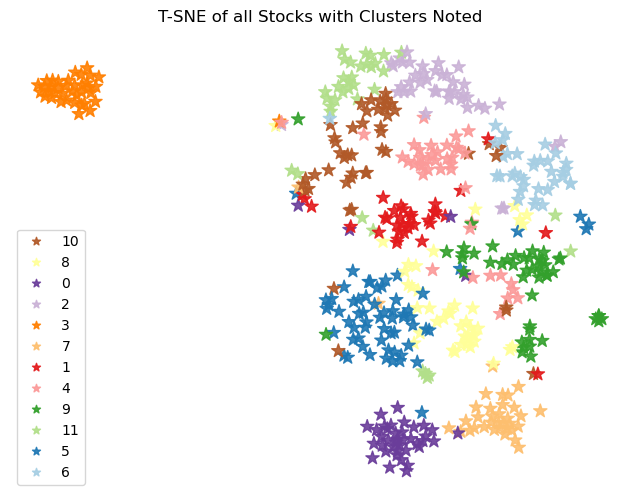


------------------------------------

Cluster counts bar chart



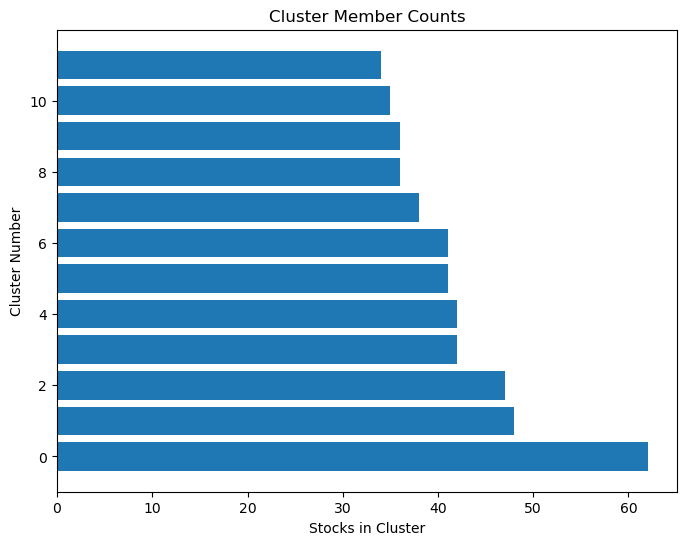


------------------------------------

Cluster member price movements: sample plots of 4 least dense clusters



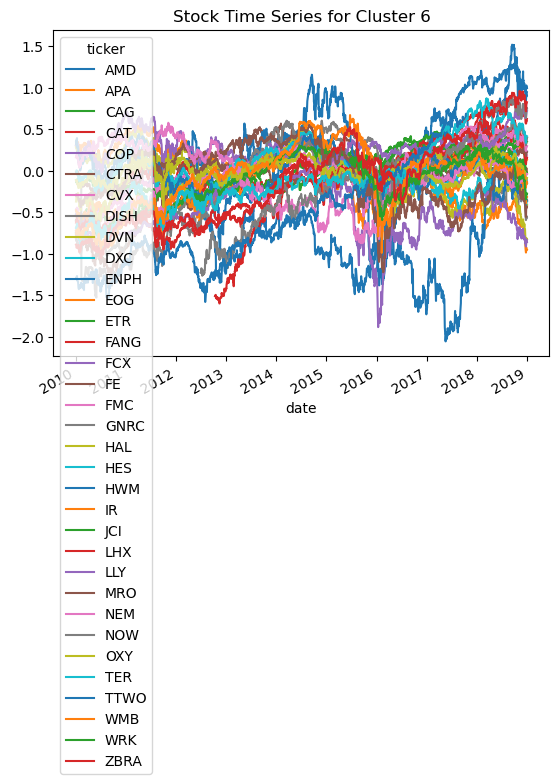

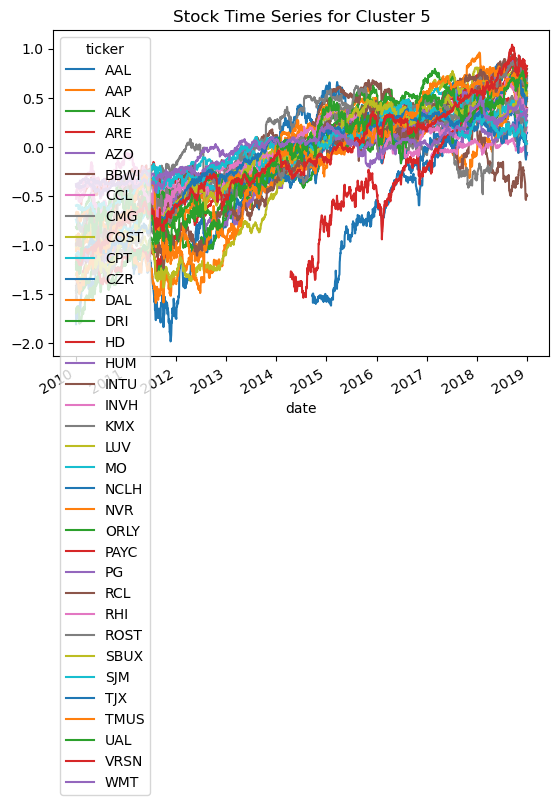

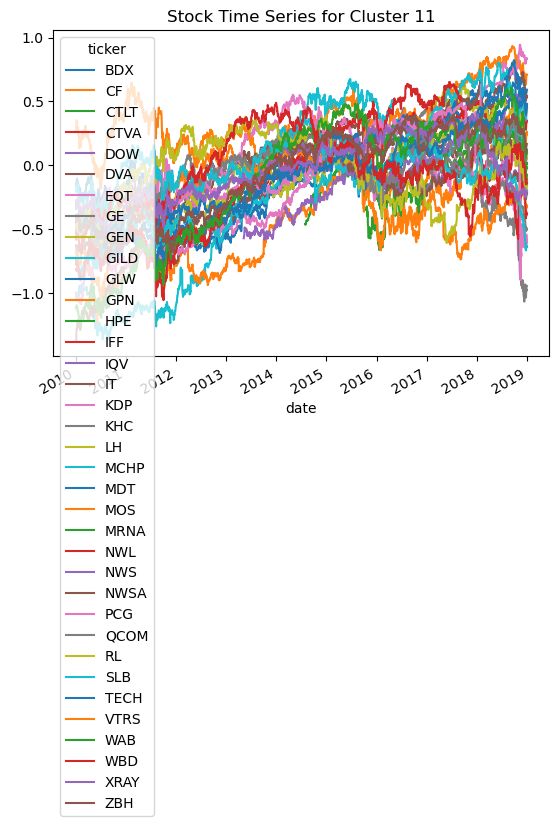

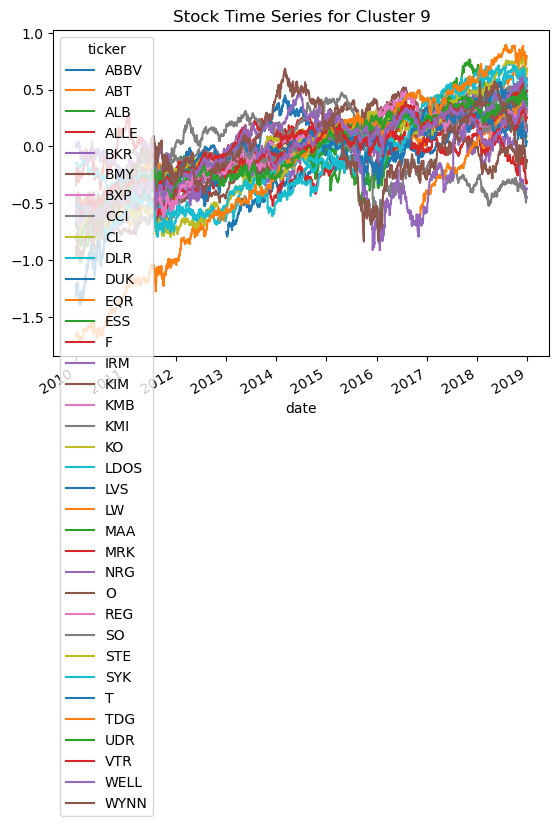

In [22]:
def km_final_plots(data, k: int, labels):
    """
    Plot all charts for the K-means model predictions 
    """
    # TSNE
    print('\n------------------------------------\n')
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('\n------------------------------------\n')
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('\n------------------------------------\n')
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

km_final_plots(ratios_final_norm_df, k_final, labels=km_final.labels_)

------

#### 3.3 OPTICS Clustering

OPTICS stands for Ordering points to identify the clustering structure. It is a density-based unsupervised learning algorithm, which was developed by the same research group that developed DBSCAN.

A single cutoff of distance is applied in DBSCAN to determine whether two data points are close to each other (neighbors) or not. But it may not always be an ideal solution because a “long” distance in one cluster could be a “short” distance in another. In OPTICS each point is assigned a core distance that describes the distance to the MinPtsth closest point, and a reachability distance of another point o from a point p that is either the distance between o and p, or the core distance of p, whichever is bigger.

Running the OPTICS model
----------------------------------------------------------------------------------------------------
max_eps: inf
min_samples: 5
model fit params: {'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 5, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.05}

db.cluster_hierarchy_: 
[[  4  12]
 [ 42  46]
 [ 47  58]
 [111 121]
 [161 172]
 [186 190]
 [185 212]
 [220 233]
 [304 310]
 [331 338]
 [347 359]
 [340 376]
 [380 388]
 [  0 496]
 [497 501]
 [  0 501]]


The Silhouette Score for our OPTICS model fit on preprocessed ratios data : -0.10687850415706635

The Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : 9.612442271666925
---------------------------------------------------------------------------------------------------------------------------------------------------------------

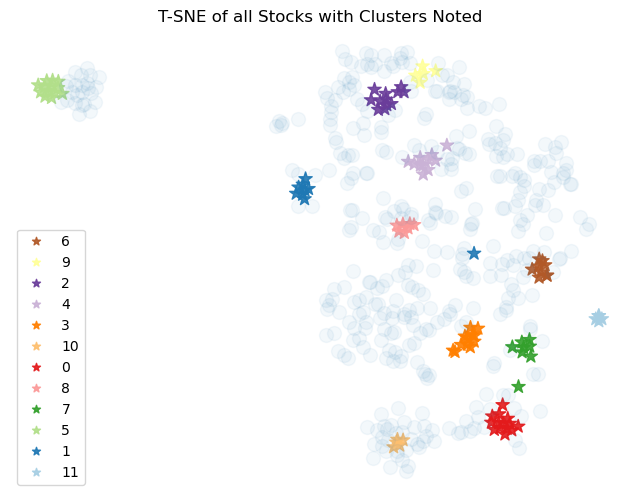

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart



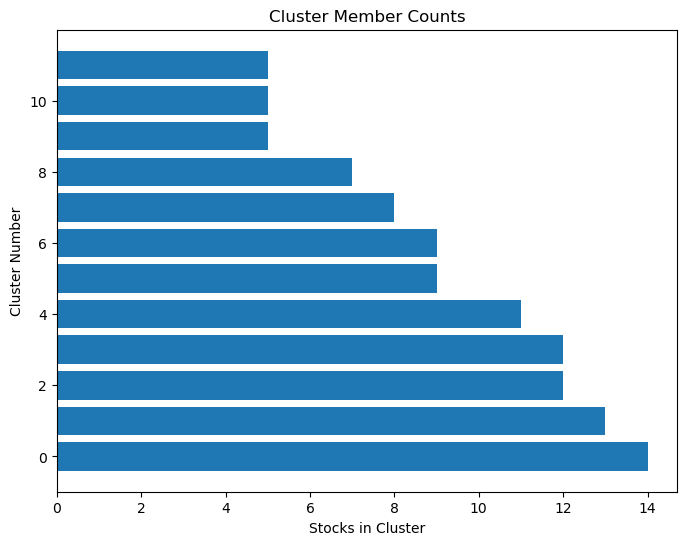

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters



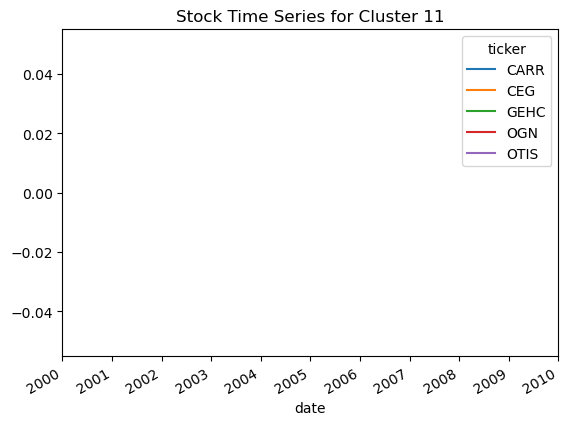

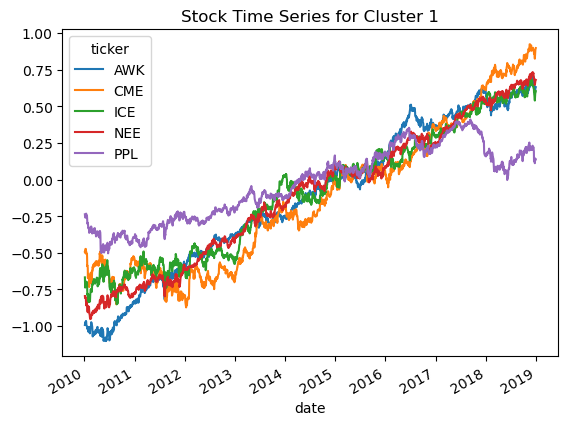

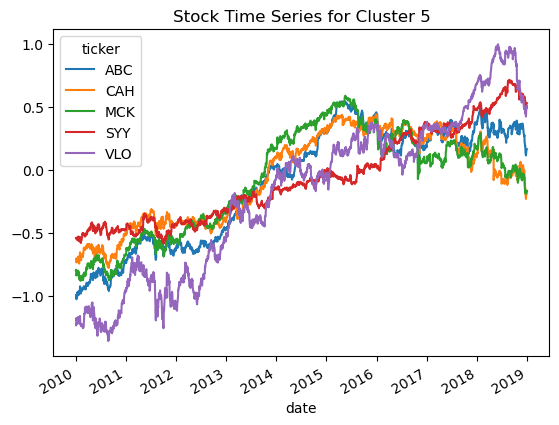

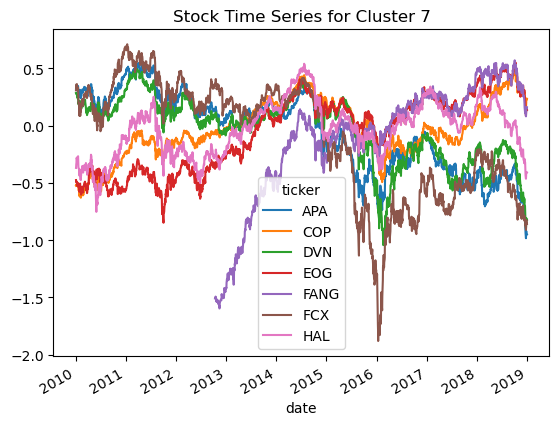

In [23]:
def optics_plots(data, max_eps: float=np.inf, min_samples: int=5):
    """
    Fit OPTICS clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running the OPTICS model')
    print('--'*50)
    print(f'max_eps: {max_eps}\nmin_samples: {min_samples}')
    db = OPTICS(max_eps=max_eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    print(f'model fit params: {db.get_params()}\n')
    print(f'db.cluster_hierarchy_: \n{db.cluster_hierarchy_}\n')

    # Compute Silouette score
    sil_score = silhouette_score(data, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our OPTICS model fit on preprocessed ratios data : {sil_score}')

    cal_hb_score = calinski_harabasz_score(data, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : {cal_hb_score}')

    # TSNE
    print('--'*100)
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

optics_plots(ratios_final_norm_df, min_samples=5)

----